In [1]:
import random
import numpy as np
import tensorflow as tf

# Fijar semillas para reproducibilidad
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Cargar el archivo nuevamente
df = pd.read_csv("df_final.csv")

# Convertir la columna de fecha
df["date_y"] = pd.to_datetime(df["date_y"])

scaler = MinMaxScaler()
scaler_y = MinMaxScaler()
# Identificar columnas que terminan con "_has_value"
has_value_columns = [col for col in df.columns if col.endswith('_has_value')]

# Identificar columnas previas a las "_has_value"
previous_columns = [
    col for col in df.columns if col + "_has_value" in has_value_columns
]

# Incluir 'mean_vote_x' en las columnas a normalizar
columns_to_normalize = previous_columns + ['mean_vote_x']

# Normalizar columnas seleccionadas
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
df['vote_y'] = scaler_y.fit_transform(df[['vote_y']])

# Extraer mes y trimestre como nuevas columnas
df["month"] = df["date_y"].dt.month
df["quarter"] = df["date_y"].dt.quarter
df = pd.get_dummies(df, columns=["month", "quarter"], drop_first=False, dtype=int)

# Mostrar las primeras filas con las nuevas columnas añadidas
df

,companyId,employeeId,date_y,vote_y,mean_vote_x,*|COMPANY_NAME|* shows commitment to the wellbeing of individuals in the organization.,*|COMPANY_NAME|* shows commitment to the wellbeing of individuals in the organization._has_value,*|COMPANY_NAME|* communicates clearly and effectively with us.,*|COMPANY_NAME|* communicates clearly and effectively with us._has_value,*|COMPANY_NAME|* is the kind of place where I could make friends.,...,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,56aec740f1ef260003e307d6,56aec740f1ef260003e307d611L,2021-03-03,1.000000,1.0000,0.0,0,0.8,1,0.0,...,0,0,0,0,0,0,1,0,0,0
1,56aec740f1ef260003e307d6,56aec740f1ef260003e307d611L,2021-09-06,1.000000,1.0000,0.0,0,0.0,0,0.5,...,0,0,1,0,0,0,0,0,1,0
2,56aec740f1ef260003e307d6,56aec740f1ef260003e307d611L,2021-12-29,1.000000,1.0000,0.0,0,0.0,0,0.0,...,0,0,0,0,0,1,0,0,0,1
3,56aec740f1ef260003e307d6,56aec740f1ef260003e307d611L,2022-03-03,0.888889,0.9575,0.5,1,0.0,0,0.5,...,0,0,0,0,0,0,1,0,0,0
4,56aec740f1ef260003e307d6,56aec740f1ef260003e307d611L,2022-06-08,0.888889,1.0000,0.0,0,0.0,0,0.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110162,663caf26181ba5284d6b6cda,663caf26181ba5284d6b6cdakO,2024-06-03,0.555556,0.6500,0.0,0,0.0,0,0.0,...,0,0,0,0,0,0,0,1,0,0
110163,663caf26181ba5284d6b6cda,663caf26181ba5284d6b6cdamY,2024-06-03,0.888889,0.9050,0.0,0,0.9,1,0.0,...,0,0,0,0,0,0,0,1,0,0
110164,663caf26181ba5284d6b6cda,663caf26181ba5284d6b6cdara,2024-06-04,0.888889,0.7500,0.0,0,0.9,1,0.0,...,0,0,0,0,0,0,0,1,0,0
110165,663caf26181ba5284d6b6cda,663caf26181ba5284d6b6cdawjk,2024-06-12,0.888889,0.7500,0.0,0,0.0,0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
# División por employeeId usando un enfoque más eficiente con pandas
from sklearn.model_selection import train_test_split
# Seleccionar IDs únicos de empleados
unique_ids = df["employeeId"].drop_duplicates()

# Dividir IDs: 70% train, 15% val, 15% test
ids_train, ids_temp = train_test_split(unique_ids, test_size=0.3)
ids_val, ids_test = train_test_split(ids_temp, test_size=0.5)

# Crear conjuntos basados en esas particiones
df_train = df[df["employeeId"].isin(ids_train)]
df_val   = df[df["employeeId"].isin(ids_val)]
df_test  = df[df["employeeId"].isin(ids_test)]

# Crear X e y con columnas relevantes
x_start_col = "mean_vote_x"
x_columns = df.columns[df.columns.get_loc(x_start_col):].tolist()

X_train, y_train = df_train[x_columns].values, df_train["vote_y"].values
X_val, y_val     = df_val[x_columns].values, df_val["vote_y"].values
X_test, y_test   = df_test[x_columns].values, df_test["vote_y"].values

# Mostrar tamaños
{
    "Train": X_train.shape,
    "Validation": X_val.shape,
    "Test": X_test.shape
}


{'Train': (77372, 125), 'Validation': (16466, 125), 'Test': (16329, 125)}

In [5]:
{
    "Train": y_train.shape,
    "Validation": y_val.shape,
    "Test": y_test.shape
}

{'Train': (77372,), 'Validation': (16466,), 'Test': (16329,)}

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath="best_mlp_base_model.keras",     # 📁 Ruta para guardar el modelo
    monitor="val_loss",                  # 🎯 Métrica a vigilar
    save_best_only=True,                # 💾 Solo guarda si mejora
    save_weights_only=False,            # 🧠 Guarda todo el modelo, no solo pesos
    verbose=1
)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam


# Definir modelo MLP
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(1)
])

# Compilar modelo
mlp_model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

# Entrenar modelo
mlp_history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/50
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1050 - mae: 0.2392
Epoch 1: val_loss improved from inf to 0.02750, saving model to best_mlp_base_model.keras
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1050 - mae: 0.2392 - val_loss: 0.0275 - val_mae: 0.1259
Epoch 2/50
1207/1209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0325 - mae: 0.1377
Epoch 2: val_loss improved from 0.02750 to 0.02312, saving model to best_mlp_base_model.keras
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0325 - mae: 0.1377 - val_loss: 0.0231 - val_mae: 0.1143
Epoch 3/50
1207/1209 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262 - mae: 0.1209
Epoch 3: val_loss improved from 0.02312 to 0.02203, saving model to best_mlp_base_model.keras
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0262 - mae: 0.1209 - val_loss: 0.0220 - val_mae: 0.1074
Epoch 4/50
1188/1209 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242 - mae: 0.1149
Epoch 4: val_loss improved from 0.02203 to 0.02198, saving mode

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model

# 1. Cargar modelo
best_loaded_model_mlp_base = load_model("best_mlp_base_model.keras")

# 2. Predecir con datos normalizados
y_pred_scaled = best_loaded_model_mlp_base.predict(X_test).flatten()

# 3. Desnormalizar
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 4. Calcular métricas en escala original
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# 5. Mostrar resultados
print("🎯 Resultados en escala original:")
print(f"📊 MSE (Error cuadrático medio): {mse:.4f}")
print(f"📏 MAE (Error absoluto medio):  {mae:.4f}")
print(f"📈 R² (Coeficiente de determinación): {r2:.4f}")


511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
🎯 Resultados en escala original:
📊 MSE (Error cuadrático medio): 1.6751
📏 MAE (Error absoluto medio):  0.9192
📈 R² (Coeficiente de determinación): 0.6163


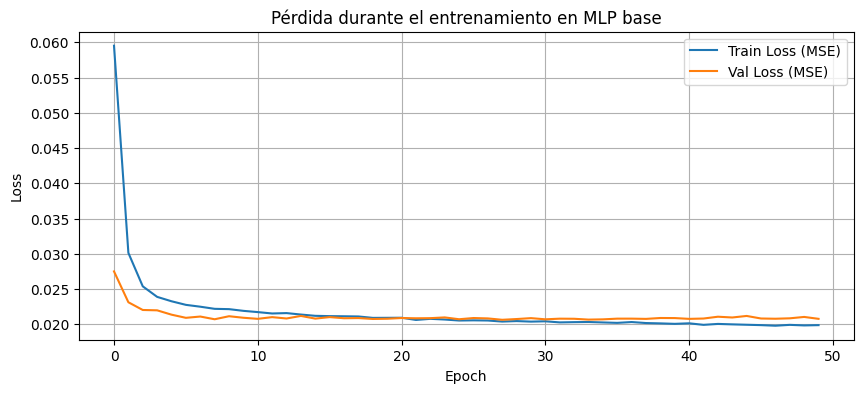

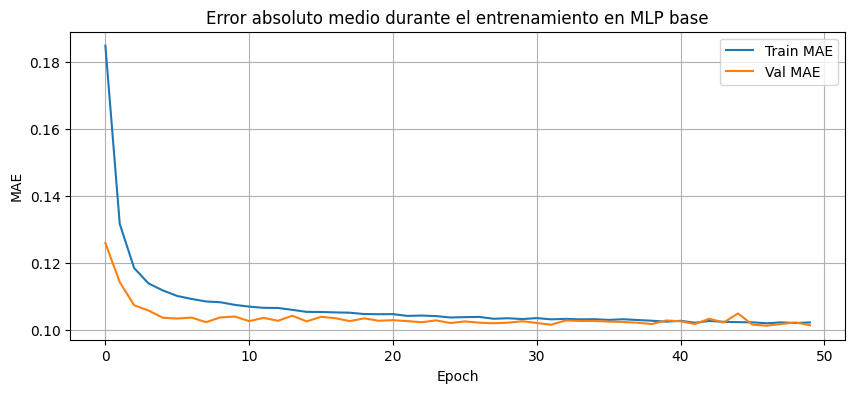

In [ ]:
import matplotlib.pyplot as plt

# --- Pérdida (MSE) ---
plt.figure(figsize=(10, 4))
plt.plot(mlp_history.history["loss"], label="Train Loss (MSE)")
plt.plot(mlp_history.history["val_loss"], label="Val Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Pérdida durante el entrenamiento en MLP base")
plt.legend()
plt.grid(True)
plt.show()

# --- MAE ---
plt.figure(figsize=(10, 4))
plt.plot(mlp_history.history["mae"], label="Train MAE")
plt.plot(mlp_history.history["val_mae"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Error absoluto medio durante el entrenamiento en MLP base")
plt.legend()
plt.grid(True)
plt.show()


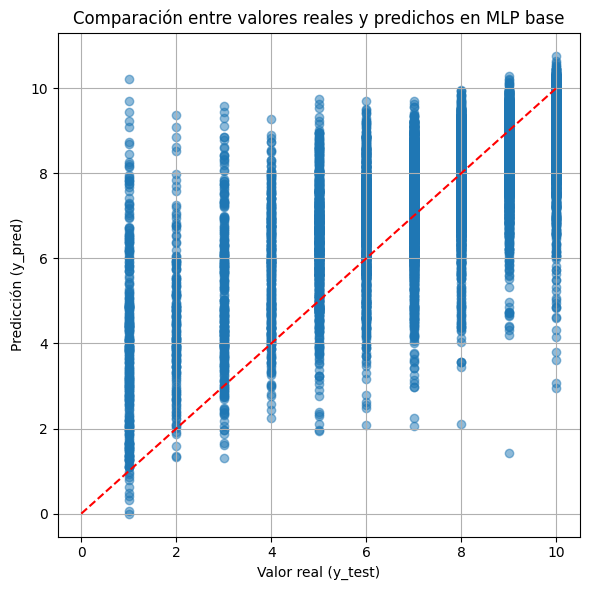

In [10]:
import matplotlib.pyplot as plt

# Scatter plot: predicción vs. valor real
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 10], [0, 10], 'r--')  # Línea de referencia: y = x
plt.xlabel("Valor real (y_test)")
plt.ylabel("Predicción (y_pred)")
plt.title("Comparación entre valores reales y predichos en MLP base")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def build_mlp_model(hp):
    model = Sequential()

    model.add(Input(shape=(X_train.shape[1],)))

    # Primera capa oculta
    model.add(Dense(
        units=hp.Int("units_1", min_value=32, max_value=128, step=32),
        activation="relu"
    ))
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.1)))

    # Segunda capa oculta opcional
    if hp.Boolean("add_second_layer"):
        model.add(Dense(
            units=hp.Int("units_2", min_value=16, max_value=64, step=16),
            activation="relu"
        ))
        model.add(Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.1)))

    # Capa de salida
    model.add(Dense(1))

    # Compilar
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_mlp_model,
    objective="val_loss",
    max_trials=50,
    executions_per_trial=1,
    directory="mlp_tuning",
    project_name="enps_mlp"
)

In [ ]:
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)
# Mostrar mejor modelo
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Mejores hiperparámetros encontrados:")
print(best_hps.values)

Trial 50 Complete [00h 00m 45s]
val_loss: 0.020813431590795517

Best val_loss So Far: 0.020457798615098
Total elapsed time: 00h 37m 18s
Mejores hiperparámetros encontrados:
{'units_1': 32, 'dropout_1': 0.1, 'add_second_layer': True, 'units_2': 64, 'dropout_2': 0.30000000000000004}


In [ ]:
checkpoint = ModelCheckpoint(
    filepath="best_hyper_mlp_model.keras",     # 📁 Ruta para guardar el modelo
    monitor="val_loss",                  # 🎯 Métrica a vigilar
    save_best_only=True,                # 💾 Solo guarda si mejora
    save_weights_only=False,            # 🧠 Guarda todo el modelo, no solo pesos
    verbose=1
)

In [ ]:
model_mlp = tuner.hypermodel.build(best_hps)
history = model_mlp.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/50
1182/1209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0866 - mae: 0.2203
Epoch 1: val_loss improved from inf to 0.02525, saving model to best_hyper_mlp_model.keras
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0858 - mae: 0.2192 - val_loss: 0.0253 - val_mae: 0.1156
Epoch 2/50
1207/1209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306 - mae: 0.1330
Epoch 2: val_loss improved from 0.02525 to 0.02242, saving model to best_hyper_mlp_model.keras
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0306 - mae: 0.1330 - val_loss: 0.0224 - val_mae: 0.1079
Epoch 3/50
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0257 - mae: 0.1190
Epoch 3: val_loss improved from 0.02242 to 0.02149, saving model to best_hyper_mlp_model.keras
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0257 - mae: 0.1190 - val_loss: 0.0215 - val_mae: 0.1048
Epoch 4/50
1199/1209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235 - mae: 0.1126
Epoch 4: val_loss improved from 0.02149 to 0.02125, saving m

In [ ]:
# 1. Cargar modelo
best_loaded_model_hyper_mlp = load_model("best_hyper_mlp_model.keras")

# 2. Predecir con datos normalizados
y_pred_scaled = best_loaded_model_hyper_mlp.predict(X_test).flatten()

# 3. Desnormalizar
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 4. Calcular métricas en escala original
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# 5. Mostrar resultados
print("🎯 Resultados en escala original:")
print(f"📊 MSE (Error cuadrático medio): {mse:.4f}")
print(f"📏 MAE (Error absoluto medio):  {mae:.4f}")
print(f"📈 R² (Coeficiente de determinación): {r2:.4f}")

511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
🎯 Resultados en escala original:
📊 MSE (Error cuadrático medio): 1.6676
📏 MAE (Error absoluto medio):  0.9167
📈 R² (Coeficiente de determinación): 0.6181


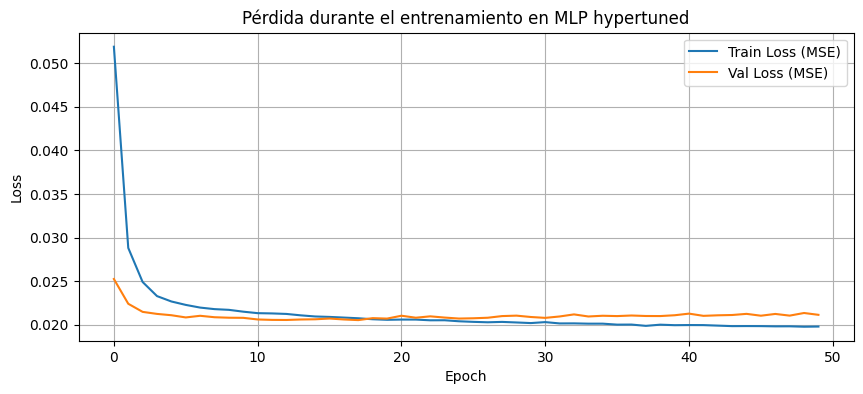

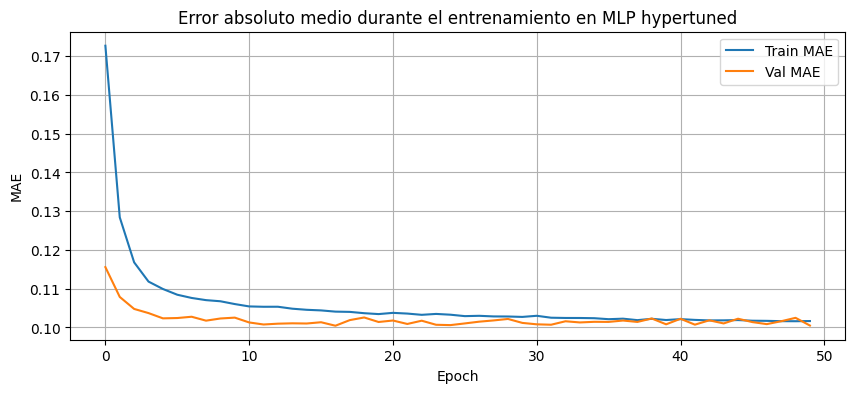

In [ ]:
# 🔵 Graficar la pérdida (MSE)
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Val Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Pérdida durante el entrenamiento en MLP hypertuned")
plt.legend()
plt.grid(True)
plt.show()

# 🟠 Graficar el MAE
plt.figure(figsize=(10, 4))
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Error absoluto medio durante el entrenamiento en MLP hypertuned")
plt.legend()
plt.grid(True)
plt.show()


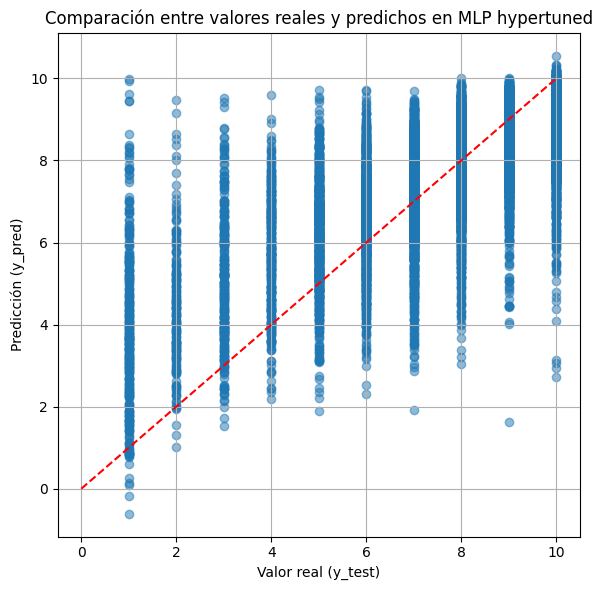

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot: predicción vs. valor real
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 10], [0, 10], 'r--')  # Línea de referencia: y = x
plt.xlabel("Valor real (y_test)")
plt.ylabel("Predicción (y_pred)")
plt.title("Comparación entre valores reales y predichos en MLP hypertuned")
plt.grid(True)
plt.tight_layout()
plt.show()